In [4]:
# Source: adapted from https://www.machinecurve.com/index.php/2019/12/30/how-to-create-a-variational-autoencoder-with-keras/#
# Visualization, clustering, and test code is my own
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
import numpy as np
import load_data
import pathlib
import matplotlib.pyplot as plt
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf

d = {"lollipop":0, "canoe":1, "penguin":2, "eyeglasses":3, "apple":4, "moon":5, "cup":6}
d_i = {0:"lollipop", 1:"canoe", 2:"penguin", 3:"eyeglasses", 4:"apple", 5:"moon", 6:"cup"}

def train_CVAE(batch_size=16, n_epochs=200, save=False, name=None):
    # Load the data
    dim_old = 28
    dat_path = pathlib.Path('object_files/').glob('*.npz')
    input_train, target_train, _, _, input_test, target_test = load_data.load_for_cnn(dat_path, 
                                                                                      dim_old, d, (0.7, 0.01), 
                                                                                      channel_axes=1, 
                                                                                      dim_new=None, 
                                                                                      binary=True)
    latent_dim = 14
    img_width, img_height = input_train.shape[1], input_train.shape[2]
    num_channels = 1
    input_shape = (img_height, img_width, num_channels)
    
    # Parse numbers as floats
    input_train = input_train.astype('float32')
    input_test = input_test.astype('float32')

    i       = Input(shape=input_shape, name='encoder_input')
    cx      = Conv2D(filters=8, kernel_size=5, strides=1, padding='same', activation='relu')(i)
    cx      = BatchNormalization()(cx)
    cx      = Conv2D(filters=16, kernel_size=5, strides=1, padding='same', activation='relu')(cx)
    cx      = BatchNormalization()(cx)
    x       = Flatten()(cx)
    x       = Dense(20, activation='relu')(x)
    x       = BatchNormalization()(x)
    mu      = Dense(latent_dim, name='latent_mu')(x)
    sigma   = Dense(latent_dim, name='latent_sigma')(x)
    conv_shape = K.int_shape(cx)

    def sample_z(args):
        mu, sigma = args
        batch     = K.shape(mu)[0]
        dim       = K.int_shape(mu)[1]
        eps       = K.random_normal(shape=(batch, dim))
        return mu + K.exp(sigma / 2) * eps

    z       = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([mu, sigma])

    encoder = Model(i, [mu, sigma, z], name='encoder')

    d_i   = Input(shape=(latent_dim, ), name='decoder_input')
    x     = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(d_i)
    x     = BatchNormalization()(x)
    x     = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
    cx    = Conv2DTranspose(filters=16, kernel_size=5, strides=1, padding='same', activation='relu')(x)
    cx    = BatchNormalization()(cx)
    cx    = Conv2DTranspose(filters=8, kernel_size=5, strides=1, padding='same', activation='relu')(cx)
    cx    = BatchNormalization()(cx)
    o     = Conv2DTranspose(filters=num_channels, kernel_size=3, activation='sigmoid', padding='same', name='decoder_output')(cx)
    decoder = Model(d_i, o, name='decoder')
    
    # Output encoder, decoder, CVAE
    encoder.summary()
    decoder.summary()
    vae_outputs = decoder(encoder(i)[2])
    vae = Model(i, vae_outputs, name='vae')
    vae.summary()
    
    # The KL divergence given here is based on 
    # https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/
    def kl_reconstruction_loss(true, pred):
        # Reconstruction loss
        reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height
        # KL divergence loss
        kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        # Total loss = 50% rec + 50% KL divergence loss
        return K.mean(reconstruction_loss + kl_loss)

    # Compile with KL divergence
    vae.compile(optimizer='adam', loss=kl_reconstruction_loss)
    history = vae.fit(input_train, input_train, epochs=n_epochs, batch_size=batch_size, validation_split=0.2)

    if save:
        encoder.save(name + '/encoder') 
        decoder.save(name + '/decoder') 
        vae.save(name + '/vae') 

    return history

In [5]:
history = train_CVAE(n_epochs=200, save=True, name="cvae_816_new")

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 28, 28, 8)    208         encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 28, 28, 8)    32          conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 28, 28, 16)   3216        batch_normalization_14[0][0]     
__________________________________________________________________________________________________
batch_norm

39200/39200 [==============================] - 214s 5ms/step - loss: 146.0493 - val_loss: 138.3825
Epoch 30/200
39200/39200 [==============================] - 210s 5ms/step - loss: 146.0338 - val_loss: 138.8127
Epoch 31/200
39200/39200 [==============================] - 182s 5ms/step - loss: 145.8600 - val_loss: 138.5706
Epoch 32/200
39200/39200 [==============================] - 211s 5ms/step - loss: 145.7802 - val_loss: 138.0997
Epoch 33/200
39200/39200 [==============================] - 211s 5ms/step - loss: 145.5505 - val_loss: 137.9925
Epoch 34/200
39200/39200 [==============================] - 204s 5ms/step - loss: 145.4594 - val_loss: 139.1589
Epoch 35/200
39200/39200 [==============================] - 203s 5ms/step - loss: 145.3831 - val_loss: 137.9993
Epoch 36/200
39200/39200 [==============================] - 200s 5ms/step - loss: 145.3042 - val_loss: 137.6639
Epoch 37/200
39200/39200 [==============================] - 200s 5ms/step - loss: 145.1938 - val_loss: 137.5374
Epoch

39200/39200 [==============================] - 352s 9ms/step - loss: 141.5620 - val_loss: 135.5360
Epoch 103/200
39200/39200 [==============================] - 358s 9ms/step - loss: 141.4093 - val_loss: 136.0742
Epoch 104/200
39200/39200 [==============================] - 260s 7ms/step - loss: 141.5678 - val_loss: 135.4684
Epoch 105/200
39200/39200 [==============================] - 307s 8ms/step - loss: 141.3144 - val_loss: 135.7334
Epoch 106/200
39200/39200 [==============================] - 407s 10ms/step - loss: 141.3762 - val_loss: 135.1674
Epoch 107/200
39200/39200 [==============================] - 384s 10ms/step - loss: 141.4919 - val_loss: 135.6297
Epoch 108/200
39200/39200 [==============================] - 420s 11ms/step - loss: 141.3643 - val_loss: 135.7399
Epoch 109/200
39200/39200 [==============================] - 265s 7ms/step - loss: 141.4508 - val_loss: 135.3856
Epoch 110/200
39200/39200 [==============================] - 224s 6ms/step - loss: 141.4124 - val_loss: 135

39200/39200 [==============================] - 287s 7ms/step - loss: 140.0440 - val_loss: 134.9513
Epoch 175/200
39200/39200 [==============================] - 275s 7ms/step - loss: 139.9333 - val_loss: 135.9719
Epoch 176/200
39200/39200 [==============================] - 235s 6ms/step - loss: 140.0300 - val_loss: 134.6377
Epoch 177/200
39200/39200 [==============================] - 230s 6ms/step - loss: 140.1054 - val_loss: 134.9814
Epoch 178/200
39200/39200 [==============================] - 282s 7ms/step - loss: 140.0643 - val_loss: 134.8587
Epoch 179/200
39200/39200 [==============================] - 196s 5ms/step - loss: 139.9265 - val_loss: 135.3299
Epoch 180/200
39200/39200 [==============================] - 191s 5ms/step - loss: 139.9527 - val_loss: 134.7037
Epoch 181/200
39200/39200 [==============================] - 187s 5ms/step - loss: 139.8217 - val_loss: 134.8330
Epoch 182/200
39200/39200 [==============================] - 187s 5ms/step - loss: 140.0598 - val_loss: 134.57

In [34]:
def viz_latent_space(encoder, data, ndim):
    assert(ndim == 2 or ndim == 3) 
    input_data, target_data = data
    target_data = tf.argmax(target_data, axis=1)
    target_data = target_data.eval(session=tf.Session())
    mu, _, _ = encoder.predict(input_data)
    pca = decomposition.PCA(n_components=ndim)
    pca.fit(mu)
    X = pca.transform(mu)
    fig = plt.figure(1, figsize=(4, 3))
    if ndim == 2:
        plt.scatter(X[:, 0], X[:, 1], c=target_data)
    else:
        ax = Axes3D(fig)
        ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=target_data)
    plt.show()
    

# TODO IMPROVE THE SAMPLING HERE!!!
def viz_decoded(encoder, decoder, data):
    num_samples = 15
    figure = np.zeros((img_width * num_samples, img_height * num_samples, num_channels))
    grid_x = np.linspace(-4, 4, num_samples)
    grid_y = np.linspace(-4, 4, num_samples)[::-1]
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.concatenate(([[xi, yi]], np.random.normal(size=(1, 12))), axis=1)
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(img_width, img_height, num_channels)
            figure[i * img_width: (i + 1) * img_width,
                  j * img_height: (j + 1) * img_height] = digit
    plt.figure(figsize=(6, 6))
    start_range = img_width // 2
    end_range = num_samples * img_width + start_range + 1
    pixel_range = np.arange(start_range, end_range, img_width)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel('z - dim 1')
    plt.ylabel('z - dim 2')
    # matplotlib.pyplot.imshow() needs a 2D array, or a 3D array with the third dimension being of shape 3 or 4!
    # So reshape if necessary
    fig_shape = np.shape(figure)
    if fig_shape[2] == 1:
        figure = figure.reshape((fig_shape[0], fig_shape[1]))
    # Show image
    plt.imshow(figure)
    plt.show()

<IPython.core.display.Javascript object>


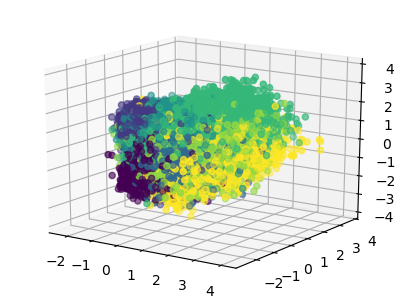

In [82]:
viz_latent_space(encoder, data, 3)

<IPython.core.display.Javascript object>


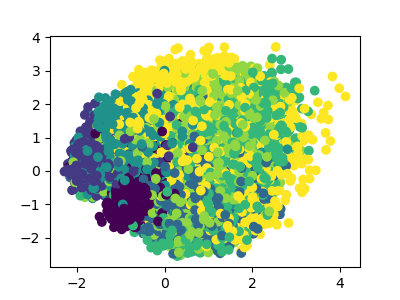

In [81]:
# Plot results
data = (input_test, target_test)
viz_latent_space(encoder, data, 2)

In [35]:
viz_decoded(encoder, decoder, data)

NameError: name 'encoder' is not defined

In [19]:
# First, make a routine that generates output from input on test images given ID, from loaded model
# This can then be used to feed to classifier

num_channels = 1
input_shape = (28, 28, num_channels)
latent_dim = 14

i       = Input(shape=input_shape, name='encoder_input')
cx      = Conv2D(filters=128, kernel_size=5, strides=1, padding='same', activation='relu')(i)
cx      = BatchNormalization()(cx)
cx      = Conv2D(filters=256, kernel_size=5, strides=1, padding='same', activation='relu')(i)
cx      = BatchNormalization()(cx)
# cx      = Conv2D(filters=512, kernel_size=5, strides=2, padding='same', activation='relu')(i)
# cx      = BatchNormalization()(cx)
# cx      = Conv2D(filters=1024, kernel_size=5, strides=2, padding='same', activation='relu')(i)
# cx      = BatchNormalization()(cx)
x       = Flatten()(cx)
x       = Dense(20, activation='relu')(x)
x       = BatchNormalization()(x)
mu      = Dense(latent_dim, name='latent_mu')(x)
sigma   = Dense(latent_dim, name='latent_sigma')(x)
conv_shape = K.int_shape(cx)

def sample_z(args):
    mu, sigma = args
    batch     = K.shape(mu)[0]
    dim       = K.int_shape(mu)[1]
    eps       = K.random_normal(shape=(batch, dim))
    return mu + K.exp(sigma / 2) * eps

z       = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([mu, sigma])

encoder = Model(i, [mu, sigma, z], name='encoder')

d_i   = Input(shape=(latent_dim, ), name='decoder_input')
x     = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(d_i)
x     = BatchNormalization()(x)
x     = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
cx    = Conv2DTranspose(filters=256, kernel_size=5, strides=1, padding='same', activation='relu')(x)
cx    = BatchNormalization()(cx)
cx    = Conv2DTranspose(filters=128, kernel_size=5, strides=1, padding='same', activation='relu')(x)
cx    = BatchNormalization()(cx)
# cx    = Conv2DTranspose(filters=256, kernel_size=5, strides=2, padding='same', activation='relu')(x)
# cx    = BatchNormalization()(cx)
# cx    = Conv2DTranspose(filters=128, kernel_size=5, strides=2, padding='same', activation='relu')(x)
# cx    = BatchNormalization()(cx)
o     = Conv2DTranspose(filters=num_channels, kernel_size=3, activation='sigmoid', padding='same', name='decoder_output')(cx)
decoder = Model(d_i, o, name='decoder')

# Output encoder, decoder, CVAE
vae_outputs = decoder(encoder(i)[2])
vae = Model(i, vae_outputs, name='vae')

def kl_reconstruction_loss(true, pred):
    # Reconstruction loss
    img_width = 28
    img_height = 28
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height
    # KL divergence loss
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    # Total loss = 50% rec + 50% KL divergence loss
    return K.mean(reconstruction_loss + kl_loss)

class CVAE_tester:
    def __init__(self, model_path, test_set, pretrained_classifier):
        self.model = tf.keras.models.load_model(model_path, compile=False)
        self.model.compile(loss=kl_reconstruction_loss)
        self.classifier = tf.keras.models.load_model(pretrained_classifier)
        self.test, self.labels = test_set
        self.N = len(self.labels)
        self.d_i = {0:"lollipop", 1:"canoe", 2:"penguin", 3:"eyeglasses", 4:"apple", 5:"moon", 6:"cup"}
    
    def gen_array(self, n):
        indices = np.random.choice(range(len(self.test)), n * n, replace=False)
        plt.figure(figsize=(2 * n, 2 * n))
        for i in range(n * n):
            plt.subplot(n, n, i+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            if i % 2 == 0:
                plt.imshow(self.test[indices[i // 2]].reshape(28,28))
                plt.xlabel(str(i//2) + ", " + self.d_i[np.argmax(self.labels[indices[i // 2]])])
            else:
                gen = self.model.predict(self.test[indices[i]].reshape(1, 28, 28, 1))
                plt.imshow(gen.reshape(28, 28))
                gen = load_data.upsample(32, gen.reshape(28, 28))
                gen = np.stack((gen, gen, gen), axis=2).reshape(1, 32, 32, 3)
                plt.xlabel(str(i//2) + ", " + self.d_i[np.argmax(self.classifier.predict(gen))] )
        plt.show()

    def test_model(self):
        gen = self.model.predict(self.test.reshape(self.N, 28, 28, 1))
        gen_upsampled = np.empty((self.N, 32, 32))
        for i in range(self.N):
            gen_upsampled[i] = load_data.upsample(32, gen[i].reshape(28, 28))
        gen = np.stack((gen_upsampled, gen_upsampled, gen_upsampled), axis=3)
        VGG_labels = np.argmax(self.classifier.predict(gen), axis=1)
        true_labels = np.argmax(self.labels, axis=1)
        correct = 0
        for i in range(self.N):
            if true_labels[i] == VGG_labels[i]:
                correct += 1
        print("Fraction of CVAE test outputs correctly classified by VGG", round(1.0 * correct / self.N, 3))

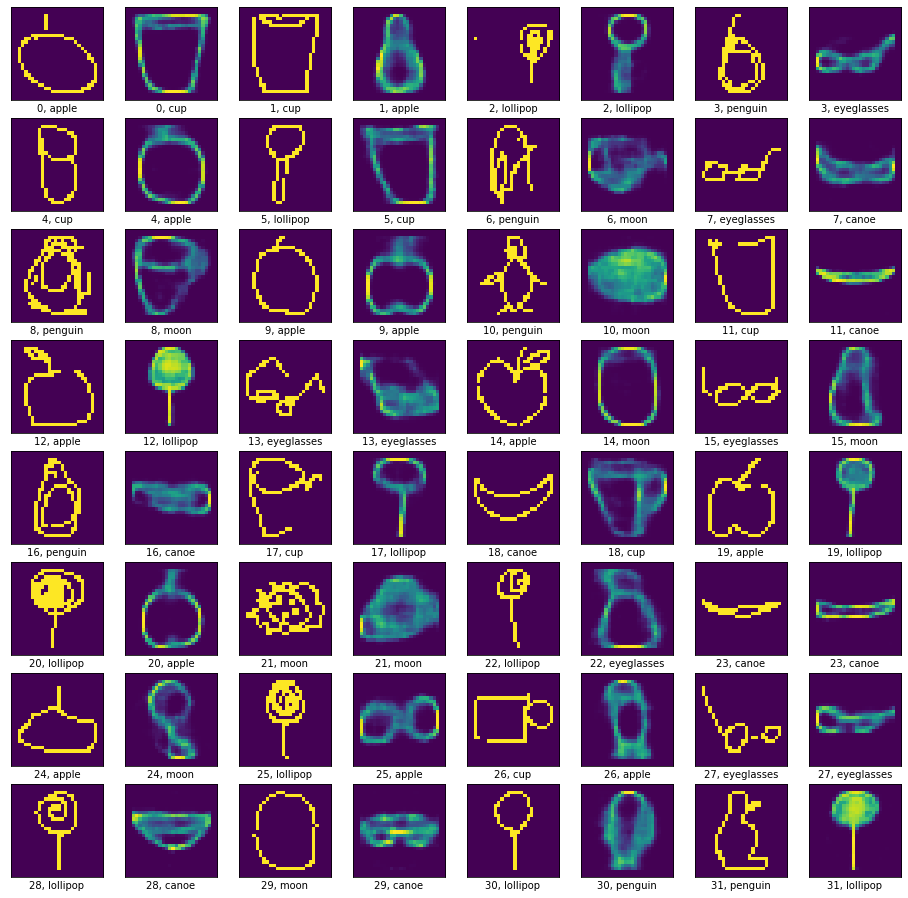

Fraction of CVAE test outputs correctly classified by VGG 0.631


In [20]:
dim_old = 28
dat_path = pathlib.Path('object_files/').glob('*.npz')
input_train, target_train, _, _, input_test, target_test = load_data.load_for_cnn(dat_path, 
                                                                                  dim_old, d, (0.7, 0.01), 
                                                                                  channel_axes=1, 
                                                                                  dim_new=None, 
                                                                                  binary=True)

tester = CVAE_tester('cvae_1/vae', (input_test, target_test), 'saved_models/VGG_model')
tester.gen_array(8)

tester.test_model()

In [96]:
# To get an idea of the latent space, try doing kmeans clustering on a bunch of models, see how 
# latent spaces change

In [ ]:
# Source: adapted from https://www.machinecurve.com/index.php/2019/12/30/how-to-create-a-variational-autoencoder-with-keras/#
# Visualization, clustering, and test code is my own
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
import numpy as np
import load_data
import pathlib
import matplotlib.pyplot as plt
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf

d = {"lollipop":0, "canoe":1, "penguin":2, "eyeglasses":3, "apple":4, "moon":5, "cup":6}
d_i = {0:"lollipop", 1:"canoe", 2:"penguin", 3:"eyeglasses", 4:"apple", 5:"moon", 6:"cup"}

def train_CVAE(batch_size=16, n_epochs=30, save=False, name=None):
    # Load the data
    dim_old = 28
    dat_path = pathlib.Path('object_files/').glob('*.npz')
    input_train, target_train, _, _, input_test, target_test = load_data.load_for_cnn(dat_path, 
                                                                                      dim_old, d, (0.7, 0.01), 
                                                                                      channel_axes=1, 
                                                                                      dim_new=None, 
                                                                                      binary=True)
    latent_dim = 14
    img_width, img_height = input_train.shape[1], input_train.shape[2]
    num_channels = 1
    input_shape = (img_height, img_width, num_channels)
    
    # Parse numbers as floats
    input_train = input_train.astype('float32')
    input_test = input_test.astype('float32')

    i       = Input(shape=input_shape, name='encoder_input')
    cx      = Conv2D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu')(i)
    cx      = BatchNormalization()(cx)
    cx      = Conv2D(filters=128, kernel_size=5, strides=1, padding='same', activation='relu')(cx)
    cx      = BatchNormalization()(cx)
    x       = Flatten()(cx)
    x       = Dense(20, activation='relu')(x)
    x       = BatchNormalization()(x)
    mu      = Dense(latent_dim, name='latent_mu')(x)
    sigma   = Dense(latent_dim, name='latent_sigma')(x)
    conv_shape = K.int_shape(cx)

    def sample_z(args):
        mu, sigma = args
        batch     = K.shape(mu)[0]
        dim       = K.int_shape(mu)[1]
        eps       = K.random_normal(shape=(batch, dim))
        return mu + K.exp(sigma / 2) * eps

    z       = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([mu, sigma])

    encoder = Model(i, [mu, sigma, z], name='encoder')

    d_i   = Input(shape=(latent_dim, ), name='decoder_input')
    x     = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(d_i)
    x     = BatchNormalization()(x)
    x     = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
    cx    = Conv2DTranspose(filters=128, kernel_size=5, strides=1, padding='same', activation='relu')(x)
    cx    = BatchNormalization()(cx)
    cx    = Conv2DTranspose(filters=64, kernel_size=5, strides=1, padding='same', activation='relu')(x)
    cx    = BatchNormalization()(cx)
    o     = Conv2DTranspose(filters=num_channels, kernel_size=3, activation='sigmoid', padding='same', name='decoder_output')(cx)
    decoder = Model(d_i, o, name='decoder')
    
    # Output encoder, decoder, CVAE
    encoder.summary()
    decoder.summary()
    vae_outputs = decoder(encoder(i)[2])
    vae = Model(i, vae_outputs, name='vae')
    vae.summary()
    
    # The KL divergence given here is based on 
    # https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/
    def kl_reconstruction_loss(true, pred):
        # Reconstruction loss
        reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height
        # KL divergence loss
        kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        # Total loss = 50% rec + 50% KL divergence loss
        return K.mean(reconstruction_loss + kl_loss)

    # Compile with KL divergence
    vae.compile(optimizer='adam', loss=kl_reconstruction_loss)
    history = vae.fit(input_train, input_train, epochs=n_epochs, batch_size=batch_size, validation_split=0.2)

    if save:
        encoder.save(name + '/encoder') 
        decoder.save(name + '/decoder') 
        vae.save(name + '/vae') 

    return history

history2 = train_CVAE(n_epochs=75, save=True, name="cvae_128256_ld_14_new")

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 28, 28, 64)   1664        encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 28, 28, 64)   256         conv2d_7[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 28, 28, 128)  204928      batch_normalization_20[0][0]     
__________________________________________________________________________________________________
batch_norm

Epoch 31/75
39200/39200 [==============================] - 1975s 50ms/step - loss: 139.1987 - val_loss: 135.1968
Epoch 32/75
39200/39200 [==============================] - 2671s 68ms/step - loss: 139.0773 - val_loss: 135.9291
Epoch 33/75
39200/39200 [==============================] - 2175s 55ms/step - loss: 138.8596 - val_loss: 134.5727
Epoch 34/75
39200/39200 [==============================] - 2370s 60ms/step - loss: 138.7265 - val_loss: 135.1036
Epoch 35/75
39200/39200 [==============================] - 2060s 53ms/step - loss: 138.4639 - val_loss: 134.5988
Epoch 36/75
 2144/39200 [>.............................] - ETA: 29:22 - loss: 138.0905

Text(0, 0.5, 'KL Divergence and Reconstruction Error')

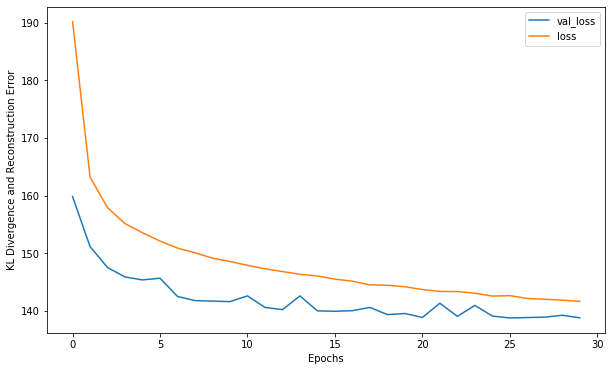

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('KL Divergence and Reconstruction Error')

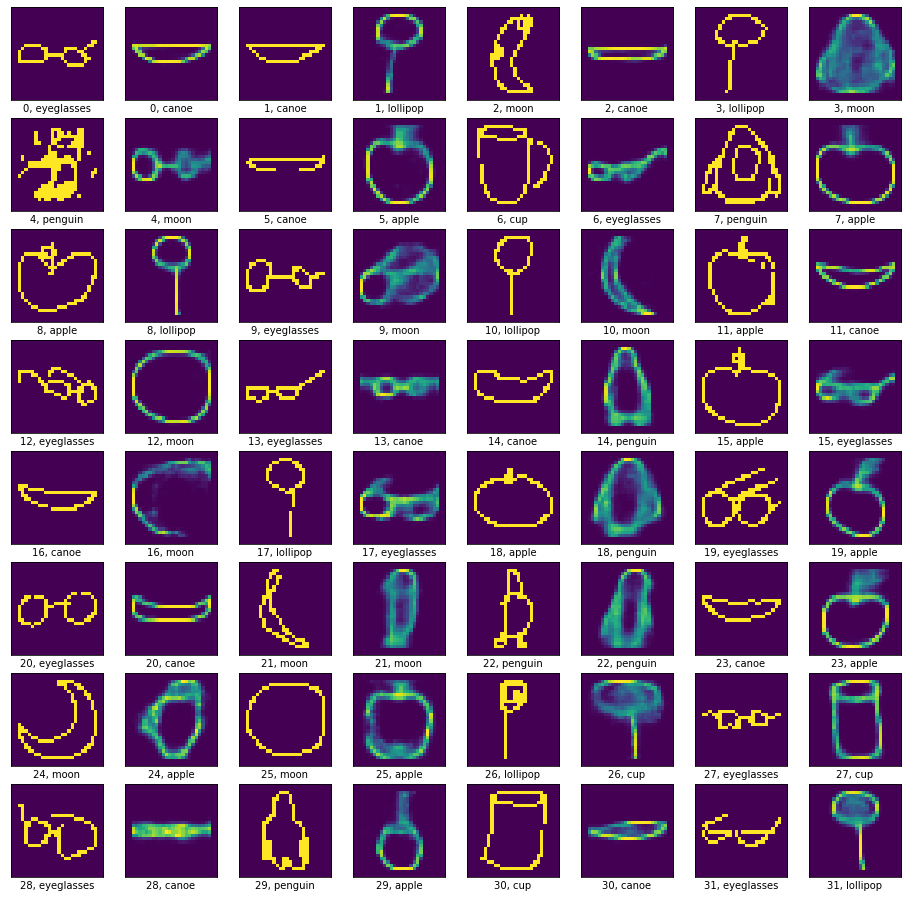

Fraction of CVAE test outputs correctly classified by VGG 0.669


In [2]:
# First, make a routine that generates output from input on test images given ID, from loaded model
# This can then be used to feed to classifier

# NB: SWITCH KERNELS BEFORE RUNNING THIS 3.7, 2.1

from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
import numpy as np
import load_data
import pathlib
import matplotlib.pyplot as plt
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf

d = {"lollipop":0, "canoe":1, "penguin":2, "eyeglasses":3, "apple":4, "moon":5, "cup":6}

num_channels = 1
input_shape = (28, 28, num_channels)
latent_dim = 14

i       = Input(shape=input_shape, name='encoder_input')
cx      = Conv2D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu')(i)
cx      = BatchNormalization()(cx)
cx      = Conv2D(filters=128, kernel_size=5, strides=1, padding='same', activation='relu')(i)
cx      = BatchNormalization()(cx)
# cx      = Conv2D(filters=512, kernel_size=5, strides=2, padding='same', activation='relu')(i)
# cx      = BatchNormalization()(cx)
# cx      = Conv2D(filters=1024, kernel_size=5, strides=2, padding='same', activation='relu')(i)
# cx      = BatchNormalization()(cx)
x       = Flatten()(cx)
x       = Dense(20, activation='relu')(x)
x       = BatchNormalization()(x)
mu      = Dense(latent_dim, name='latent_mu')(x)
sigma   = Dense(latent_dim, name='latent_sigma')(x)
conv_shape = K.int_shape(cx)

def sample_z(args):
    mu, sigma = args
    batch     = K.shape(mu)[0]
    dim       = K.int_shape(mu)[1]
    eps       = K.random_normal(shape=(batch, dim))
    return mu + K.exp(sigma / 2) * eps

z       = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([mu, sigma])

encoder = Model(i, [mu, sigma, z], name='encoder')

d_i   = Input(shape=(latent_dim, ), name='decoder_input')
x     = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(d_i)
x     = BatchNormalization()(x)
x     = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
cx    = Conv2DTranspose(filters=128, kernel_size=5, strides=1, padding='same', activation='relu')(x)
cx    = BatchNormalization()(cx)
cx    = Conv2DTranspose(filters=64, kernel_size=5, strides=1, padding='same', activation='relu')(x)
cx    = BatchNormalization()(cx)
# cx    = Conv2DTranspose(filters=256, kernel_size=5, strides=2, padding='same', activation='relu')(x)
# cx    = BatchNormalization()(cx)
# cx    = Conv2DTranspose(filters=128, kernel_size=5, strides=2, padding='same', activation='relu')(x)
# cx    = BatchNormalization()(cx)
o     = Conv2DTranspose(filters=num_channels, kernel_size=3, activation='sigmoid', padding='same', name='decoder_output')(cx)
decoder = Model(d_i, o, name='decoder')

# Output encoder, decoder, CVAE
vae_outputs = decoder(encoder(i)[2])
vae = Model(i, vae_outputs, name='vae')

def kl_reconstruction_loss(true, pred):
    # Reconstruction loss
    img_width = 28
    img_height = 28
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height
    # KL divergence loss
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    # Total loss = 50% rec + 50% KL divergence loss
    return K.mean(reconstruction_loss + kl_loss)

class CVAE_tester:
    def __init__(self, model_path, test_set, pretrained_classifier):
        self.model = tf.keras.models.load_model(model_path, compile=False)
        self.model.compile(loss=kl_reconstruction_loss)
        self.classifier = tf.keras.models.load_model(pretrained_classifier)
        self.test, self.labels = test_set
        self.N = len(self.labels)
        self.d_i = {0:"lollipop", 1:"canoe", 2:"penguin", 3:"eyeglasses", 4:"apple", 5:"moon", 6:"cup"}
    
    def gen_array(self, n):
        indices = np.random.choice(range(len(self.test)), n * n, replace=False)
        plt.figure(figsize=(2 * n, 2 * n))
        for i in range(n * n):
            plt.subplot(n, n, i+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            if i % 2 == 0:
                plt.imshow(self.test[indices[i // 2]].reshape(28,28))
                plt.xlabel(str(i//2) + ", " + self.d_i[np.argmax(self.labels[indices[i // 2]])])
            else:
                gen = self.model.predict(self.test[indices[i]].reshape(1, 28, 28, 1))
                plt.imshow(gen.reshape(28, 28))
                gen = load_data.upsample(32, gen.reshape(28, 28))
                gen = np.stack((gen, gen, gen), axis=2).reshape(1, 32, 32, 3)
                plt.xlabel(str(i//2) + ", " + self.d_i[np.argmax(self.classifier.predict(gen))] )
        plt.show()

    def test_model(self):
        gen = self.model.predict(self.test.reshape(self.N, 28, 28, 1))
        gen_upsampled = np.empty((self.N, 32, 32))
        for i in range(self.N):
            gen_upsampled[i] = load_data.upsample(32, gen[i].reshape(28, 28))
        gen = np.stack((gen_upsampled, gen_upsampled, gen_upsampled), axis=3)
        VGG_labels = np.argmax(self.classifier.predict(gen), axis=1)
        true_labels = np.argmax(self.labels, axis=1)
        correct = 0
        for i in range(self.N):
            if true_labels[i] == VGG_labels[i]:
                correct += 1
        print("Fraction of CVAE test outputs correctly classified by VGG", round(1.0 * correct / self.N, 3))
        
dim_old = 28
dat_path = pathlib.Path('object_files/').glob('*.npz')
input_train, target_train, _, _, input_test, target_test = load_data.load_for_cnn(dat_path, 
                                                                                  dim_old, d, (0.7, 0.01), 
                                                                                  channel_axes=1, 
                                                                                  dim_new=None, 
                                                                                  binary=True)

tester = CVAE_tester('cvae_128256_ld_14/vae', (input_test, target_test), 'saved_models/VGG_model')
tester.gen_array(8)

tester.test_model()

In [2]:
# For fun, let's compare this to a basically nonexistent latent space
# Source: adapted from https://www.machinecurve.com/index.php/2019/12/30/how-to-create-a-variational-autoencoder-with-keras/#
# Visualization, clustering, and test code is my own
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
import numpy as np
import load_data
import pathlib
import matplotlib.pyplot as plt
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf

d = {"lollipop":0, "canoe":1, "penguin":2, "eyeglasses":3, "apple":4, "moon":5, "cup":6}
d_i = {0:"lollipop", 1:"canoe", 2:"penguin", 3:"eyeglasses", 4:"apple", 5:"moon", 6:"cup"}

def train_CVAE(batch_size=16, n_epochs=30, save=False, name=None):
    # Load the data
    dim_old = 28
    dat_path = pathlib.Path('object_files/').glob('*.npz')
    input_train, target_train, _, _, input_test, target_test = load_data.load_for_cnn(dat_path, 
                                                                                      dim_old, d, (0.7, 0.01), 
                                                                                      channel_axes=1, 
                                                                                      dim_new=None, 
                                                                                      binary=True)
    latent_dim = 2
    img_width, img_height = input_train.shape[1], input_train.shape[2]
    num_channels = 1
    input_shape = (img_height, img_width, num_channels)
    
    # Parse numbers as floats
    input_train = input_train.astype('float32')
    input_test = input_test.astype('float32')


    i       = Input(shape=input_shape, name='encoder_input')
    cx      = Conv2D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu')(i)
    cx      = BatchNormalization()(cx)
    cx      = Conv2D(filters=128, kernel_size=5, strides=1, padding='same', activation='relu')(i)
    cx      = BatchNormalization()(cx)
    # cx      = Conv2D(filters=512, kernel_size=5, strides=2, padding='same', activation='relu')(i)
    # cx      = BatchNormalization()(cx)
    # cx      = Conv2D(filters=1024, kernel_size=5, strides=2, padding='same', activation='relu')(i)
    # cx      = BatchNormalization()(cx)
    x       = Flatten()(cx)
    x       = Dense(20, activation='relu')(x)
    x       = BatchNormalization()(x)
    mu      = Dense(latent_dim, name='latent_mu')(x)
    sigma   = Dense(latent_dim, name='latent_sigma')(x)
    conv_shape = K.int_shape(cx)

    def sample_z(args):
        mu, sigma = args
        batch     = K.shape(mu)[0]
        dim       = K.int_shape(mu)[1]
        eps       = K.random_normal(shape=(batch, dim))
        return mu + K.exp(sigma / 2) * eps

    z       = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([mu, sigma])

    encoder = Model(i, [mu, sigma, z], name='encoder')

    d_i   = Input(shape=(latent_dim, ), name='decoder_input')
    x     = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(d_i)
    x     = BatchNormalization()(x)
    x     = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
    cx    = Conv2DTranspose(filters=128, kernel_size=5, strides=1, padding='same', activation='relu')(x)
    cx    = BatchNormalization()(cx)
    cx    = Conv2DTranspose(filters=64, kernel_size=5, strides=1, padding='same', activation='relu')(x)
    cx    = BatchNormalization()(cx)
    # cx    = Conv2DTranspose(filters=256, kernel_size=5, strides=2, padding='same', activation='relu')(x)
    # cx    = BatchNormalization()(cx)
    # cx    = Conv2DTranspose(filters=128, kernel_size=5, strides=2, padding='same', activation='relu')(x)
    # cx    = BatchNormalization()(cx)
    o     = Conv2DTranspose(filters=num_channels, kernel_size=3, activation='sigmoid', padding='same', name='decoder_output')(cx)
    decoder = Model(d_i, o, name='decoder')
    
    # Output encoder, decoder, CVAE
    encoder.summary()
    decoder.summary()
    vae_outputs = decoder(encoder(i)[2])
    vae = Model(i, vae_outputs, name='vae')
    vae.summary()
    
    # The KL divergence given here is based on 
    # https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/
    def kl_reconstruction_loss(true, pred):
        # Reconstruction loss
        reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height
        # KL divergence loss
        kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        # Total loss = 50% rec + 50% KL divergence loss
        return K.mean(reconstruction_loss + kl_loss)

    # Compile with KL divergence
    vae.compile(optimizer='adam', loss=kl_reconstruction_loss)
    history = vae.fit(input_train, input_train, epochs=n_epochs, batch_size=batch_size, validation_split=0.2)

    if save:
        encoder.save(name + '/encoder') 
        decoder.save(name + '/decoder') 
        vae.save(name + '/vae') 

    return history

history = train_CVAE(n_epochs=50, save=True, name="cvae_128256_ld_2")

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 28, 28, 128)  3328        encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 28, 28, 128)  512         conv2d_3[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 100352)       0           batch_normalization_7[0][0]      
__________________________________________________________________________________________________
dense_2 (D

39200/39200 [==============================] - 826s 21ms/step - loss: 178.0645 - val_loss: 177.1070
Epoch 35/50
39200/39200 [==============================] - 821s 21ms/step - loss: 178.1706 - val_loss: 176.8501
Epoch 36/50
39200/39200 [==============================] - 821s 21ms/step - loss: 178.1427 - val_loss: 176.3264
Epoch 37/50
39200/39200 [==============================] - 823s 21ms/step - loss: 177.9618 - val_loss: 177.1308
Epoch 38/50
39200/39200 [==============================] - 817s 21ms/step - loss: 177.7831 - val_loss: 176.4319
Epoch 39/50
39200/39200 [==============================] - 817s 21ms/step - loss: 177.6996 - val_loss: 176.1331
Epoch 40/50
39200/39200 [==============================] - 819s 21ms/step - loss: 177.6471 - val_loss: 176.5432
Epoch 41/50
39200/39200 [==============================] - 820s 21ms/step - loss: 177.7529 - val_loss: 176.6142
Epoch 42/50
39200/39200 [==============================] - 816s 21ms/step - loss: 177.4714 - val_loss: 176.6612
Epoc

(170, 205)

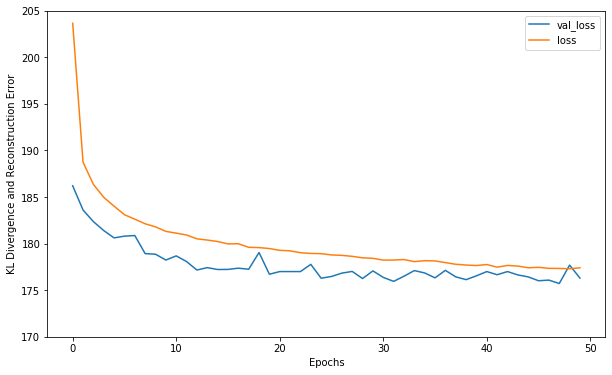

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('KL Divergence and Reconstruction Error')
plt.ylim(170, 205)

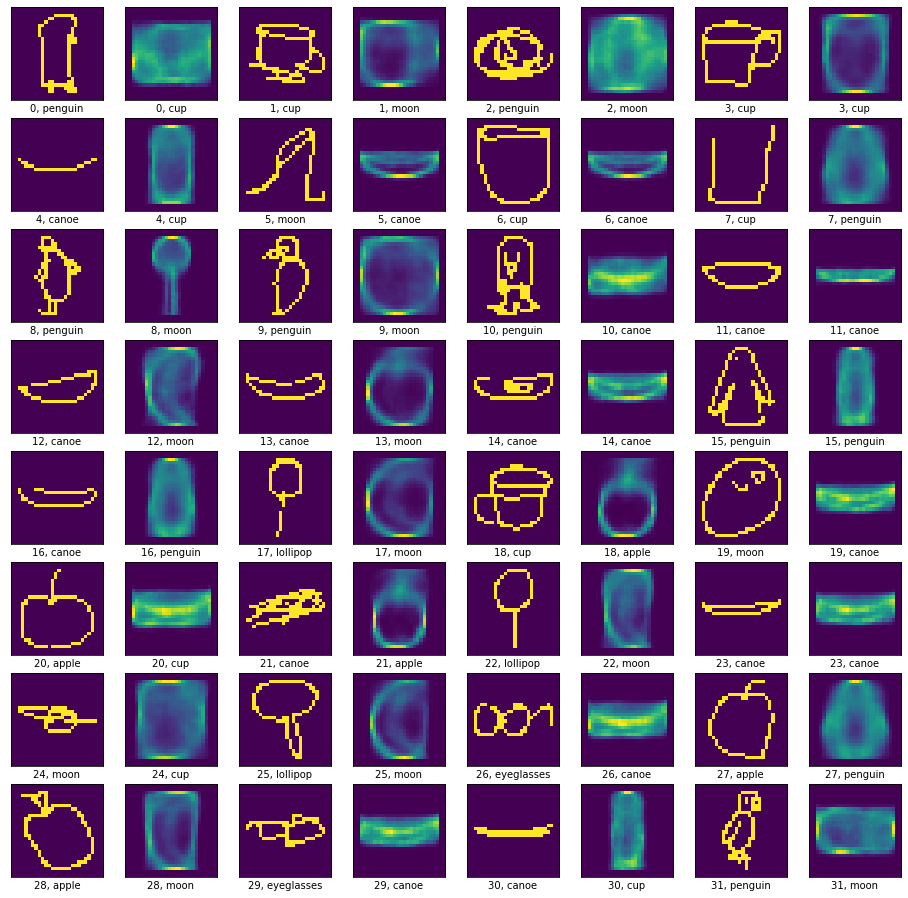

Fraction of CVAE test outputs correctly classified by VGG 0.453


In [2]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
import numpy as np
import load_data
import pathlib
import matplotlib.pyplot as plt
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf

d = {"lollipop":0, "canoe":1, "penguin":2, "eyeglasses":3, "apple":4, "moon":5, "cup":6}

num_channels = 1
input_shape = (28, 28, num_channels)
latent_dim = 2

i       = Input(shape=input_shape, name='encoder_input')
cx      = Conv2D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu')(i)
cx      = BatchNormalization()(cx)
cx      = Conv2D(filters=128, kernel_size=5, strides=1, padding='same', activation='relu')(i)
cx      = BatchNormalization()(cx)
# cx      = Conv2D(filters=512, kernel_size=5, strides=2, padding='same', activation='relu')(i)
# cx      = BatchNormalization()(cx)
# cx      = Conv2D(filters=1024, kernel_size=5, strides=2, padding='same', activation='relu')(i)
# cx      = BatchNormalization()(cx)
x       = Flatten()(cx)
x       = Dense(20, activation='relu')(x)
x       = BatchNormalization()(x)
mu      = Dense(latent_dim, name='latent_mu')(x)
sigma   = Dense(latent_dim, name='latent_sigma')(x)
conv_shape = K.int_shape(cx)

def sample_z(args):
    mu, sigma = args
    batch     = K.shape(mu)[0]
    dim       = K.int_shape(mu)[1]
    eps       = K.random_normal(shape=(batch, dim))
    return mu + K.exp(sigma / 2) * eps

z       = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([mu, sigma])

encoder = Model(i, [mu, sigma, z], name='encoder')

d_i   = Input(shape=(latent_dim, ), name='decoder_input')
x     = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(d_i)
x     = BatchNormalization()(x)
x     = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
cx    = Conv2DTranspose(filters=128, kernel_size=5, strides=1, padding='same', activation='relu')(x)
cx    = BatchNormalization()(cx)
cx    = Conv2DTranspose(filters=64, kernel_size=5, strides=1, padding='same', activation='relu')(x)
cx    = BatchNormalization()(cx)
# cx    = Conv2DTranspose(filters=256, kernel_size=5, strides=2, padding='same', activation='relu')(x)
# cx    = BatchNormalization()(cx)
# cx    = Conv2DTranspose(filters=128, kernel_size=5, strides=2, padding='same', activation='relu')(x)
# cx    = BatchNormalization()(cx)
o     = Conv2DTranspose(filters=num_channels, kernel_size=3, activation='sigmoid', padding='same', name='decoder_output')(cx)
decoder = Model(d_i, o, name='decoder')

# Output encoder, decoder, CVAE
vae_outputs = decoder(encoder(i)[2])
vae = Model(i, vae_outputs, name='vae')

def kl_reconstruction_loss(true, pred):
    # Reconstruction loss
    img_width = 28
    img_height = 28
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height
    # KL divergence loss
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    # Total loss = 50% rec + 50% KL divergence loss
    return K.mean(reconstruction_loss + kl_loss)

class CVAE_tester:
    def __init__(self, model_path, test_set, pretrained_classifier):
        self.model = tf.keras.models.load_model(model_path, compile=False)
        self.model.compile(loss=kl_reconstruction_loss)
        self.classifier = tf.keras.models.load_model(pretrained_classifier)
        self.test, self.labels = test_set
        self.N = len(self.labels)
        self.d_i = {0:"lollipop", 1:"canoe", 2:"penguin", 3:"eyeglasses", 4:"apple", 5:"moon", 6:"cup"}
    
    def gen_array(self, n):
        indices = np.random.choice(range(len(self.test)), n * n, replace=False)
        plt.figure(figsize=(2 * n, 2 * n))
        for i in range(n * n):
            plt.subplot(n, n, i+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            if i % 2 == 0:
                plt.imshow(self.test[indices[i // 2]].reshape(28,28))
                plt.xlabel(str(i//2) + ", " + self.d_i[np.argmax(self.labels[indices[i // 2]])])
            else:
                gen = self.model.predict(self.test[indices[i]].reshape(1, 28, 28, 1))
                plt.imshow(gen.reshape(28, 28))
                gen = load_data.upsample(32, gen.reshape(28, 28))
                gen = np.stack((gen, gen, gen), axis=2).reshape(1, 32, 32, 3)
                plt.xlabel(str(i//2) + ", " + self.d_i[np.argmax(self.classifier.predict(gen))] )
        plt.show()

    def test_model(self):
        gen = self.model.predict(self.test.reshape(self.N, 28, 28, 1))
        gen_upsampled = np.empty((self.N, 32, 32))
        for i in range(self.N):
            gen_upsampled[i] = load_data.upsample(32, gen[i].reshape(28, 28))
        gen = np.stack((gen_upsampled, gen_upsampled, gen_upsampled), axis=3)
        VGG_labels = np.argmax(self.classifier.predict(gen), axis=1)
        true_labels = np.argmax(self.labels, axis=1)
        correct = 0
        for i in range(self.N):
            if true_labels[i] == VGG_labels[i]:
                correct += 1
        print("Fraction of CVAE test outputs correctly classified by VGG", round(1.0 * correct / self.N, 3))
        
dim_old = 28
dat_path = pathlib.Path('object_files/').glob('*.npz')
input_train, target_train, _, _, input_test, target_test = load_data.load_for_cnn(dat_path, 
                                                                                  dim_old, d, (0.7, 0.01), 
                                                                                  channel_axes=1, 
                                                                                  dim_new=None, 
                                                                                  binary=True)

tester = CVAE_tester('cvae_128256_ld_2/vae', (input_test, target_test), 'saved_models/VGG_model')
tester.gen_array(8)

tester.test_model()

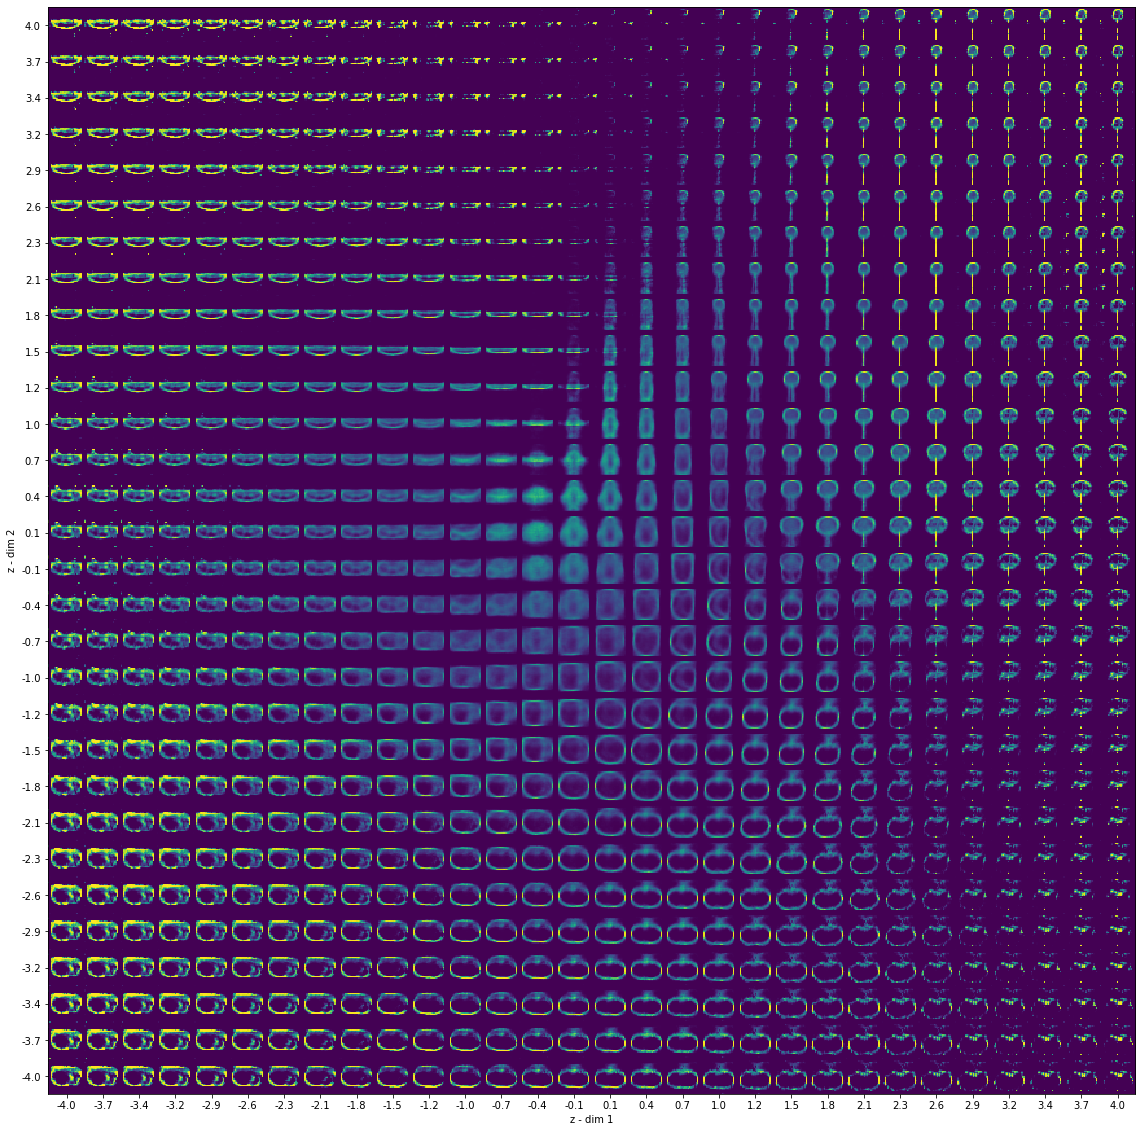

In [9]:
# Also since we only have two latent dimensions, we can do the nice latent space visualization
def viz_decoded(encoder, decoder, data): 
    img_width = 28
    img_height = 28
    num_samples = 30  
    figure = np.zeros((img_width * num_samples, img_height * num_samples, num_channels))  
    grid_x = np.linspace(-4, 4, num_samples)  
    grid_y = np.linspace(-4, 4, num_samples)[::-1]  
    for i, yi in enumerate(grid_y):      
        for j, xi in enumerate(grid_x):          
            z_sample = np.array([[xi, yi]])          
            x_decoded = decoder.predict(z_sample)          
            digit = x_decoded[0].reshape(img_width, img_height, num_channels)          
            figure[i * img_width: (i + 1) * img_width,                  
                   j * img_height: (j + 1) * img_height] = digit  
    plt.figure(figsize=(20, 20))  
    start_range = img_width // 2  
    end_range = num_samples * img_width + start_range + 1  
    pixel_range = np.arange(start_range, end_range, img_width)  
    sample_range_x = np.round(grid_x, 1)  
    sample_range_y = np.round(grid_y, 1)  
    plt.xticks(pixel_range, sample_range_x)  
    plt.yticks(pixel_range, sample_range_y)  
    plt.xlabel('z - dim 1')  
    plt.ylabel('z - dim 2')  
    # matplotlib.pyplot.imshow() needs a 2D array, or a 3D array with the third dimension being of shape 3 or 4!  
    # So reshape if necessary  
    fig_shape = np.shape(figure)  
    if fig_shape[2] == 1:    
        figure = figure.reshape((fig_shape[0], fig_shape[1]))  
    # Show image  
    plt.imshow(figure)  
    plt.show()
    
encoder = tf.keras.models.load_model('cvae_128256_ld_2/encoder', compile=False)
decoder = tf.keras.models.load_model('cvae_128256_ld_2/decoder', compile=False) 

viz_decoded(encoder, decoder, (input_test, target_test))

In [1]:
# For fun, let's compare this to a basically nonexistent latent space
# Source: adapted from https://www.machinecurve.com/index.php/2019/12/30/how-to-create-a-variational-autoencoder-with-keras/#
# Visualization, clustering, and test code is my own
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
import numpy as np
import load_data
import pathlib
import matplotlib.pyplot as plt
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf

d = {"lollipop":0, "canoe":1, "penguin":2, "eyeglasses":3, "apple":4, "moon":5, "cup":6}
d_i = {0:"lollipop", 1:"canoe", 2:"penguin", 3:"eyeglasses", 4:"apple", 5:"moon", 6:"cup"}

def train_CVAE(batch_size=16, n_epochs=30, save=False, name=None):
    # Load the data
    dim_old = 28
    dat_path = pathlib.Path('object_files/').glob('*.npz')
    input_train, target_train, _, _, input_test, target_test = load_data.load_for_cnn(dat_path, 
                                                                                      dim_old, d, (0.7, 0.01), 
                                                                                      channel_axes=1, 
                                                                                      dim_new=None, 
                                                                                      binary=True)
    latent_dim = 2
    img_width, img_height = input_train.shape[1], input_train.shape[2]
    num_channels = 1
    input_shape = (img_height, img_width, num_channels)
    
    # Parse numbers as floats
    input_train = input_train.astype('float32')
    input_test = input_test.astype('float32')


    i       = Input(shape=input_shape, name='encoder_input')
    cx      = Conv2D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu')(i)
    cx      = BatchNormalization()(cx)
    cx      = Conv2D(filters=128, kernel_size=5, strides=1, padding='same', activation='relu')(i)
    cx      = BatchNormalization()(cx)
    cx      = Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu')(i)
    cx      = BatchNormalization()(cx)
    cx      = Conv2D(filters=512, kernel_size=3, strides=1, padding='same', activation='relu')(i)
    cx      = BatchNormalization()(cx)
    x       = Flatten()(cx)
    x       = Dense(20, activation='relu')(x)
    x       = BatchNormalization()(x)
    mu      = Dense(latent_dim, name='latent_mu')(x)
    sigma   = Dense(latent_dim, name='latent_sigma')(x)
    conv_shape = K.int_shape(cx)

    def sample_z(args):
        mu, sigma = args
        batch     = K.shape(mu)[0]
        dim       = K.int_shape(mu)[1]
        eps       = K.random_normal(shape=(batch, dim))
        return mu + K.exp(sigma / 2) * eps

    z       = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([mu, sigma])

    encoder = Model(i, [mu, sigma, z], name='encoder')

    d_i   = Input(shape=(latent_dim, ), name='decoder_input')
    x     = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(d_i)
    x     = BatchNormalization()(x)
    x     = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
    cx    = Conv2DTranspose(filters=256, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    cx    = BatchNormalization()(cx)
    cx    = Conv2DTranspose(filters=256, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    cx    = BatchNormalization()(cx)
    cx    = Conv2DTranspose(filters=128, kernel_size=5, strides=1, padding='same', activation='relu')(x)
    cx    = BatchNormalization()(cx)
    cx    = Conv2DTranspose(filters=64, kernel_size=5, strides=1, padding='same', activation='relu')(x)
    cx    = BatchNormalization()(cx)
    o     = Conv2DTranspose(filters=num_channels, kernel_size=3, activation='sigmoid', padding='same', name='decoder_output')(cx)
    decoder = Model(d_i, o, name='decoder')
    
    # Output encoder, decoder, CVAE
    encoder.summary()
    decoder.summary()
    vae_outputs = decoder(encoder(i)[2])
    vae = Model(i, vae_outputs, name='vae')
    vae.summary()
    
    # The KL divergence given here is based on 
    # https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/
    def kl_reconstruction_loss(true, pred):
        # Reconstruction loss
        reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height
        # KL divergence loss
        kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        # Total loss = 50% rec + 50% KL divergence loss
        return K.mean(reconstruction_loss + kl_loss)

    # Compile with KL divergence
    vae.compile(optimizer='adam', loss=kl_reconstruction_loss)
    history = vae.fit(input_train, input_train, epochs=n_epochs, batch_size=batch_size, validation_split=0.2)

    if save:
        encoder.save(name + '/encoder') 
        decoder.save(name + '/decoder') 
        vae.save(name + '/vae') 

    return history

history = train_CVAE(n_epochs=50, save=True, name="cvae_64128256_ld_2")

/Users/mburhanpurkar/.miniconda3/envs/tf112/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/mburhanpurkar/.miniconda3/envs/tf112/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/mburhanpurkar/.miniconda3/envs/tf112/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/mburhanpurka

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 256)  6656        encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 14, 14, 256)  1024        conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten (Flatten)               (None, 50176)        0           batch_normalization_2[0][0]      
__________________________________________________________________________________________________
dense (Den

KeyboardInterrupt: 